# Part1 Chpater03_04 얼굴 특징 분류

## 1. 데이터 불러오기
1) 어노테이션 파일을 불러온다.</br>
2) 데이터의 기본 속성을 파악한다. (데이터 개수, 클래스 개수, 클래스 개수 분포 등)

In [1]:
import os
import pandas as pd

'''
    어노테이션 파일을 불러온다.
'''

data_root = '../part1_chapter03_04'
annotation_filename = 'annotations.csv'

annotations = pd.read_csv(os.path.join(data_root, annotation_filename))

annotations.head()

,filepath,asian,us,man,woman
0,asian_woman/asian_woman_87.jpg,1,0,0,1
1,asian_man/asian_man_88.jpg,1,0,1,0
2,us_woman/us_woman_80.jpg,0,1,0,1
3,us_man/us_man_107.jpg,0,1,1,0
4,us_man/us_man_95.jpg,0,1,1,0


In [2]:
class_list = annotations.columns[1:]
for cls in class_list:
    print(annotations[cls].value_counts())
    print()
print(f'데이터 개수 : {len(annotations)}')
print(f'클래스 개수 : {len(class_list)}')

asian
0    382
1    369
Name: count, dtype: int64

us
1    382
0    369
Name: count, dtype: int64

man
1    376
0    375
Name: count, dtype: int64

woman
0    376
1    375
Name: count, dtype: int64

데이터 개수 : 751
클래스 개수 : 4


# 2. 데이터 시각화
 1) 어노테이션을 랜덤으로 섞는다.</br>
 2) 전체 데이터 샘플을 시각화 한다.</br>
 3) 클래스별 데이터 샘플을 시각화 한다.

In [3]:
import matplotlib.pyplot as plt
'''
    이미지 시각화 함수를 정의한다. 
'''

def draw_images(images, classes):
    '''
        :param images: cv2(ndarray) 이미지 리스트
        :param classes: 클래스 리스트
        :return: None 
    '''
    # 4x2의 그리드 생성 (바둑판 이미지 틀 생성)
    fig, axs = plt.subplots(2, 4)
    
    # 각 하위 그래프에 이미지 출력
    for i, ax in enumerate(axs.flat):
        ax.imshow(images[i]) # 이미지를 바둑판에 출력
        ax.set_title(classes[i]) # 클래스 이름으로 이미지 제목 생성 
        # ax.axis('off') # 축 숨기기
    
    plt.tight_layout()
    plt.show()

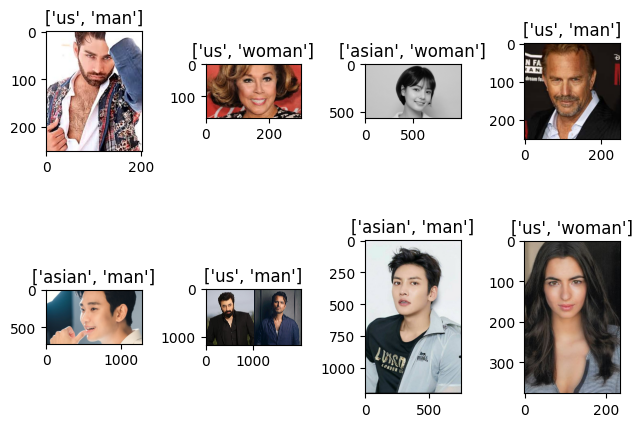

In [4]:
from PIL import Image
import numpy as np
import random

'''
    데이터를 랜덤하게 셔플하고 시각화를 수행한다.
'''

annotations = annotations.sample(frac=1).reset_index(drop=True)
sample_images = [] # 이미지 샘플 저장
sample_classes = [] # 이미지 클래스 저장
sample_cnt = 0 # 시작 count
max_cnt = 8 # 종류 count
for idx, annot in annotations.iterrows():
    classes = []
    for cls in class_list:
        if int(annot[cls]) == 1:
            classes.append(cls)
    sample_classes.append(classes)
    image_path = os.path.join(data_root, annot['filepath'])
    image = Image.open(image_path).convert('RGB')
    sample_images.append(np.array(image))
    sample_cnt += 1
    if sample_cnt == max_cnt:
        break

## 전체 데이터 샘플을 시각화 한다.
draw_images(sample_images, sample_classes)

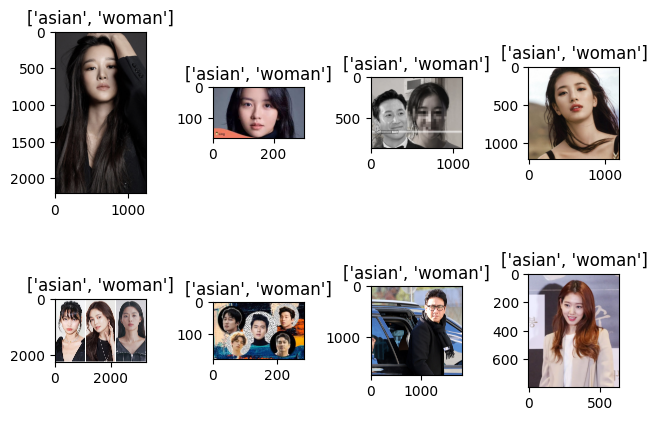

In [5]:
from PIL import Image
import numpy as np
import random

'''
    클래스별 데이터를 시각화 한다.
'''

annotations = annotations.sample(frac=1).reset_index(drop=True)
find_cls = ['asian', 'woman']
sample_images = [] # 이미지 샘플 저장
sample_classes = [] # 이미지 클래스 저장
sample_cnt = 0 # 시작 count
max_cnt = 8 # 종류 count
for idx, annot in annotations.iterrows():
    classes = []
    for cls in class_list:
        if int(annot[cls]) == 1:
            classes.append(cls)
    if (classes[0] in find_cls) and (classes[1] in find_cls):  
        sample_classes.append(classes)
        image_path = os.path.join(data_root, annot['filepath'])
        image = Image.open(image_path).convert('RGB')
        sample_images.append(np.array(image))
        sample_cnt += 1
        if sample_cnt == max_cnt:
            break
    else:
        continue

## 전체 데이터 샘플을 시각화 한다.
draw_images(sample_images, sample_classes)

# 3. 데이터세트 클래스 생성
1) csv 데이터를 파싱하고 출력하는 커스텀 데이터세트 클래스를 생성한다.</br>
2) 데이터세트의 출력 값을 확인한다.

In [7]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset

'''
    csv 데이터를 파싱하는 커스텀 데이터세트 클래스를 선언한다.
'''

class CsvDataset(Dataset):
    def __init__(self, 
                 data_root,
                 annotations,
                 transform=None):
        '''
            :param data_root: 데이터셋의 루트 경로 
            :param annotations: 어노테이션
            :param transform: 이미지 변환 모듈
        '''
        self.data_root = data_root
        self.annotations = annotations
        self.transform = transform
        self.class_list = self._get_classes() # 클래스의 목록
        self.num_classes = len(self.class_list) # 클래스 개수
        
    def __len__(self):
        return len(self.annotations) # 데이터 개수

    def __getitem__(self, idx):
        '''
            :param idx:  
            :return:
                image : 입력 이미지 데이터 (텐서 또는 pillow 이미지)
                target : 정답 클래스 데이터 (원-핫 벡터)
                    예) [1.0, 0.0, 0.0, 1.0, 0.0, ...]
        '''
        annot = self.annotations.iloc[idx]
        image_path = os.path.join(self.data_root, annot['filepath'])
        image = Image.open(image_path).convert("RGB")
        
        '''
            원-핫 벡터를 생성한다.
            예) [0.0, 1.0, 0.0, 0.0, 1.0, ...]
        '''
        target = []
        for cls_num, cls in enumerate(self.class_list):
            if int(annot[cls]) == 1:
                target.append(cls_num)
        target = F.one_hot(torch.tensor(target), self.num_classes).sum(dim=0).to(torch.float)
        
        '''
            albumentations에 맞게 변경
        '''
        if self.transform:
            image = self.transform(image=np.array(image))['image']

        return image, target
    
    def _get_classes(self):
        '''
        :return: 클래스의 리스트를 반환한다. 각 인덱스는 클래스 번호가 된다.
            예) ['blue', 'shirts', 'dress', ...] => blue: 0번 클래스, shirts: 1번 클래스, ... 
        '''
        class_list = []
        columns = self.annotations.columns
        for col in columns:
            if col != 'filepath':
                class_list.append(col)
        
        class_list.sort()
        return class_list

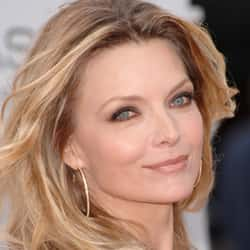

In [8]:
'''
    데이터세트의 출력 값을 시각화 한다.
'''
dataset = CsvDataset(data_root=data_root,
                     annotations=annotations)
data = dataset[0]
data[0]

In [9]:
print(data[1])
print(dataset.class_list)

tensor([0., 0., 1., 1.])
['asian', 'man', 'us', 'woman']


# 4. 학습 및 검증 데이터 분할

In [10]:
'''
    원본 데이터셋을 학습과 검증셋으로 분할한다.
'''
annotations = annotations.sample(frac=1).reset_index(drop=True)
len_annot = len(annotations)
train_annot = annotations.iloc[ : int(len_annot * 0.9)]
val_annot = annotations.iloc[int(len_annot * 0.9) : ]

print(f'학습 데이터 개수 : {len(train_annot)}')
print(f'검증 데이터 개수 : {len(val_annot)}')

학습 데이터 개수 : 675
검증 데이터 개수 : 76


# 5. 모델 학습 준비
1. 학습에 필요한 하이퍼파라미터를 선언한다.</br>
2. 이미지 변환 모듈을 적용한 데이터세트의 샘플을 확인한다.</br>
3. 이미지 변환 모듈을 적용한 학습 및 검증 데이터세트를 생성한다.</br>
4. 학습 및 검증 데이터 로더를 생성한다.


In [13]:
'''
    학습에 필요한 하이퍼파라미터를 선언한다.
'''
hyper_params = {
    'num_epochs': 5,
    'lr': 0.0001,
    'score_threshold': 0.5, # 모델의 출력값에 대한 임계값
    'image_size': 224,
    'train_batch_size': 8,
    'val_batch_size': 4,
    'print_preq': 0.1 # 학습 중 로그 출력 빈도
}

In [16]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
'''
    albumentations 이미지 변환 모듈을 적용한 데이터세트의 결과물을 확인한다.
'''

# 샘플 이미지 변환 모듈 설정
sample_transform = A.Compose([
    A.CLAHE(p=0.5),
    A.Blur(p=0.5),
    A.ShiftScaleRotate(p=0.5, border_mode=0),
    A.OpticalDistortion(),
    A.GridDistortion(),
    A.HueSaturationValue(),
    A.Resize(height=224, width=224),
    # A.Normalize(p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ## 이미지 픽셀 값 정규화
    # ToTensorV2() ## 모델에 입력할 때 사용
])

sample_dataset = CsvDataset(data_root, train_annot, sample_transform)

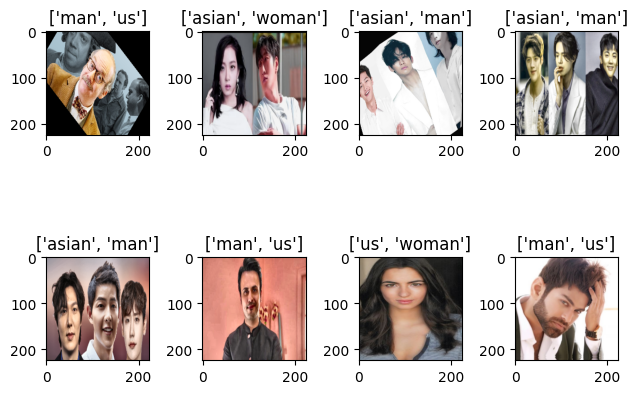

In [17]:
transformed_images = []
targets = []

## 데이터세트에서 변환된 이미지와 target 벡터를 불러온다.
max_cnt = 8
for idx, (image, target) in enumerate(sample_dataset):
    if idx == max_cnt:
        break
    transformed_images.append(image)
    targets.append(target.tolist())

## 타켓 벡터를 클래스로 변환한다.
target_classes = []
class_list = sample_dataset.class_list
for target in targets:
    classes = []
    for cls, val in enumerate(target):
        if int(val) == 1:
            classes.append(class_list[cls])
    target_classes.append(classes)

draw_images(transformed_images, target_classes)

In [18]:
'''
    이미지 변환 모듈을 적용한 학습 및 검증 데이터세트를 생성한다.
    학습 및 검증 데이터 로더를 생성한다.
'''

# 학습 및 검증 이미지 변환 모듈 설정
train_transform = A.Compose([
    A.CLAHE(p=0.5),
    A.Blur(p=0.5),
    A.ShiftScaleRotate(p=0.5, border_mode=0),
    A.OpticalDistortion(),
    A.GridDistortion(),
    A.HueSaturationValue(),
    A.Resize(height=224, width=224),
    A.Normalize(p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ## 이미지 픽셀 값 정규화
    ToTensorV2() ## 모델에 입력할 때 사용
])

val_transform = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ## 이미지 픽셀 값 정규화
    ToTensorV2() ## 모델에 입력할 때 사용
])

# 학습 데이터세트 및 데이터로더 설정
train_dataset = CsvDataset(data_root, train_annot, train_transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=hyper_params['train_batch_size'], shuffle=True)

# 검증 데이터세트 및 데이터로더 설정
val_dataset = CsvDataset(data_root, val_annot, val_transform)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=hyper_params['val_batch_size'], shuffle=False)

# 6. 모델 생성
1) VGG16 모델을 불러온다.</br>
2) 클래스 개수에 맞게 출력 레이어를 변경한다.

In [19]:
import torch
import torch.nn as nn
from torchvision import models
import timm

'''
    timm 라이브러리로 모델을 불러온다.
'''
def get_model(model_name, num_classes, weight_path='', device='cpu'):
    model = timm.create_model(model_name, 
                              pretrained=True, 
                              num_classes=num_classes)
    if weight_path:
        model.load_state_dict(torch.load(weight_path, map_location='cpu'))
    model.to(device)

    return model

In [20]:

model = get_model('resnet18', num_classes=train_dataset.num_classes)

In [21]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

# 7. 모델 학습 및 검증
   1) loss함수와 옵티마이저를 설정한다.</br>
   2) 학습 루프를 실행한다.</br>
   3) 1 epoch 마다 검증 루프를 실행한다.

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score


# loss 함수와 옵티마이저 설정
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=hyper_params['lr'])

# 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = hyper_params['num_epochs']

# 학습 루프
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    epoch_loss = 0.0
    print_cnt = int(len(train_dataloader) * hyper_params['print_preq'])

    for idx, (images, targets) in enumerate(train_dataloader):
        images, targets = images.to(device), targets.to(device)
        
        # forward
        outputs = model(images)
        loss = criterion(outputs, targets)

        # backward & update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        epoch_loss += loss.item()
        
        if idx % print_cnt == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], "
                  f"Iter [{idx}/{len(train_dataloader)}] "
                  f"Loss: {running_loss/print_cnt:.4f}")
            running_loss = 0.0
        
        

    # 한 epoch이 끝날 때마다 loss 총 합 출력
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_dataloader):.4f}")

    # F1-score 계산 및 출력
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, targets in val_dataloader:
            images = images.to(device)
            outputs = torch.sigmoid(model(images)) # 시그모이드로 출력값 변환
            preds = (outputs > hyper_params['score_threshold']).float()  # threshold 설정 (정답값 선택)
            y_true.extend(targets.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    f1 = f1_score(y_true, y_pred, average='micro')  # F1-score 계산
    print(f"F1-score: {f1:.4f}")

Epoch [1/5], Iter [0/85] Loss: 0.0877
Epoch [1/5], Iter [8/85] Loss: 0.6989
Epoch [1/5], Iter [16/85] Loss: 0.6860
Epoch [1/5], Iter [24/85] Loss: 0.6882
Epoch [1/5], Iter [32/85] Loss: 0.6862
Epoch [1/5], Iter [40/85] Loss: 0.6840
Epoch [1/5], Iter [48/85] Loss: 0.6851
Epoch [1/5], Iter [56/85] Loss: 0.6951
Epoch [1/5], Iter [64/85] Loss: 0.6796
Epoch [1/5], Iter [72/85] Loss: 0.6727
Epoch [1/5], Iter [80/85] Loss: 0.6620
Epoch [1/5], Loss: 0.6840
F1-score: 0.7276
Epoch [2/5], Iter [0/85] Loss: 0.0861
Epoch [2/5], Iter [8/85] Loss: 0.6651
Epoch [2/5], Iter [16/85] Loss: 0.6626
Epoch [2/5], Iter [24/85] Loss: 0.6611
Epoch [2/5], Iter [32/85] Loss: 0.6626
Epoch [2/5], Iter [40/85] Loss: 0.6658
Epoch [2/5], Iter [48/85] Loss: 0.6435
Epoch [2/5], Iter [56/85] Loss: 0.6399
Epoch [2/5], Iter [64/85] Loss: 0.6420
Epoch [2/5], Iter [72/85] Loss: 0.6477
Epoch [2/5], Iter [80/85] Loss: 0.6424
Epoch [2/5], Loss: 0.6523
F1-score: 0.8194
Epoch [3/5], Iter [0/85] Loss: 0.0783
Epoch [3/5], Iter [8/8

In [23]:
import json

'''
    학습 결과 모델과 하이퍼파라미터를 저장한다.
'''
model_save_dir = './train_results'
os.makedirs(model_save_dir, exist_ok=True)
model_save_path = os.path.join(model_save_dir, 'model.pth')

torch.save(model.state_dict(), model_save_path)

param_save_path = os.path.join(model_save_dir, 'hyper_params.json') 
with open(param_save_path, 'w')as json_f:
    json.dump(hyper_params, json_f, indent='\t', ensure_ascii=False)

# 8. 모델 테스트
1) 학습한 모델의 가중치를 불러온다.</br>
2) 모델 추론 결과를 확인한다.

In [27]:
'''
    모델을 선언하고 학습한 모델의 가중치를 불러온다.
'''
model = get_model(model_name='resnet18', 
                  num_classes=train_dataset.num_classes, 
                  weight_path='./train_results/model.pth')

In [38]:
'''
    모델의 추론을 수행한다.
'''
image_list = []
pred_list = []

val_cnt = 8
cnt = 0
with torch.no_grad():
    model.eval()
    for idx, annot in val_annot.iterrows():
        if cnt == val_cnt:
            break
        cnt += 1
        image_path = os.path.join(data_root, annot['filepath'])
        print(f'image_path : {image_path}')
        image = Image.open(image_path).convert('RGB')
        image_list.append(image)
        input_image = val_transform(image=np.array(image))['image'].unsqueeze(0).to(device)

        outputs = torch.sigmoid(model(input_image))[0]
        preds = (outputs > hyper_params['score_threshold']).int().tolist() # threshold 설정
        pred_list.append(preds)

image_path : ../part1_chapter03_04/asian_woman/asian_woman_70.jpg
image_path : ../part1_chapter03_04/asian_woman/asian_woman_57.jpg
image_path : ../part1_chapter03_04/asian_woman/asian_woman_113.jpg
image_path : ../part1_chapter03_04/asian_man/asian_man_133.jpg
image_path : ../part1_chapter03_04/asian_man/asian_man_95.jpg
image_path : ../part1_chapter03_04/asian_man/asian_man_11.jpg
image_path : ../part1_chapter03_04/us_man/us_man_46.jpg
image_path : ../part1_chapter03_04/us_woman/us_woman_4.jpg


In [39]:
'''
    모델의 추론 결과(클래스 번호)를 클래스 이름으로 변경한다
'''
class_list = train_dataset.class_list
pred_class_list = []
for pred in pred_list:
    pred_class = []
    for cls, val in enumerate(pred):
        if int(val) == 1:
            pred_class.append(class_list[cls])
    pred_class_list.append(pred_class)

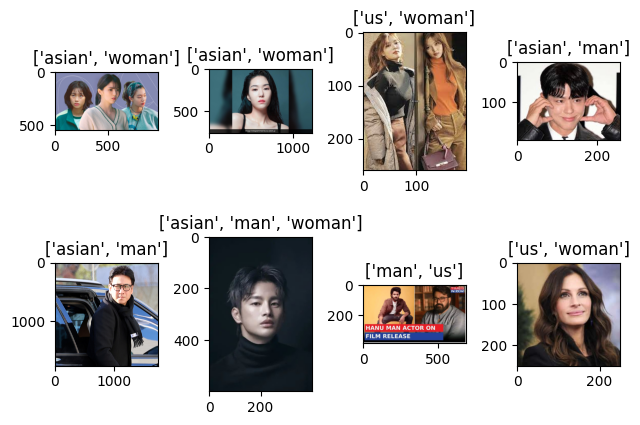

In [40]:
draw_images(image_list, pred_class_list)

# 9. 검증 데이터의 f1-score를 확인한다.

In [41]:
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_metrics(val_dataloader, score_threshold, class_list):
    metric_df = pd.DataFrame(columns=['class', 'precision', 'recall', 'f1'])
    
    # F1-score 계산 및 출력
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, targets in val_dataloader:
            images = images.to(device)
            outputs = torch.sigmoid(model(images))
            preds = (outputs > score_threshold).float()  # threshold 설정, 여기서는 0.5로 가정
            y_true.extend(targets.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    f1 = f1_score(y_true, y_pred, average=None)  # F1-score 계산
    
    metric_df['class'] = class_list
    metric_df['precision'] = precision
    metric_df['recall'] = recall
    metric_df['f1'] = f1
    
    return metric_df

In [42]:
metric_df = calculate_metrics(val_dataloader, hyper_params['score_threshold'], class_list)
metric_df.head()

,class,precision,recall,f1
0,asian,0.862464,0.917683,0.889217
1,man,0.837696,0.955224,0.892608
2,us,0.923780,0.873199,0.897778
3,woman,0.907051,0.832353,0.868098
